In [1]:
import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk import FreqDist
from wordcloud import WordCloud
import seaborn as sns
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tag.perceptron import PerceptronTagger
import re

In [2]:
# Loading the training set and the cleaned resources data
training = pd.read_csv('train.csv')
resources = pd.read_csv('cleaned_resources.csv')

In [3]:
# There are some teacher prefixes that are missing and ~2/3 of the essay 3 and 4 are missing as well.
# Those will have to be dealt with.
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182080 entries, 0 to 182079
Data columns (total 16 columns):
id                                              182080 non-null object
teacher_id                                      182080 non-null object
teacher_prefix                                  182076 non-null object
school_state                                    182080 non-null object
project_submitted_datetime                      182080 non-null object
project_grade_category                          182080 non-null object
project_subject_categories                      182080 non-null object
project_subject_subcategories                   182080 non-null object
project_title                                   182080 non-null object
project_essay_1                                 182080 non-null object
project_essay_2                                 182080 non-null object
project_essay_3                                 6374 non-null object
project_essay_4                        

In [4]:
# There are no missing values for this data
resources.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260115 entries, 0 to 260114
Data columns (total 7 columns):
id              260115 non-null object
quantity        260115 non-null int64
total_price     260115 non-null float64
min_quantity    260115 non-null int64
max_quantity    260115 non-null int64
min_price       260115 non-null float64
max_price       260115 non-null float64
dtypes: float64(3), int64(3), object(1)
memory usage: 13.9+ MB


In [5]:
# The data column is stored as a string so this converts the column to a datetime object
training['project_submitted_datetime'] = pd.to_datetime(training['project_submitted_datetime'])

In [6]:
# The resources data shows the breakdown of the requested supplies and it is grouped by the project ID. We can merge these two dataframes on the ID column using a left join. The left dataframe is the training data and the right dataframe is the resources. The left join will keep all values of the left dataframe and only keep the values that match from the right dataframe.
training = training.merge(resources, how='left', left_on='id', right_on='id')

In [7]:
training.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,...,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,quantity,total_price,min_quantity,max_quantity,min_price,max_price
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,...,NaN,My students need 6 Ipod Nano's to create and d...,26,1,6,899.94,3,3,449.97,449.97
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,...,NaN,My students need matching shirts to wear for d...,1,0,20,400.00,20,20,400.00,400.00
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,...,NaN,My students need the 3doodler. We are an SEM s...,5,1,1,469.99,1,1,469.99,469.99
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,...,NaN,My students need balls and other activity equi...,16,0,5,684.47,1,1,18.95,354.99
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,...,NaN,My students need a water filtration system for...,42,1,2,711.00,2,2,711.00,711.00


In [8]:
# The are many more projects approved compared to projects not approved.
training['project_is_approved'].value_counts()

1    154346
0     27734
Name: project_is_approved, dtype: int64

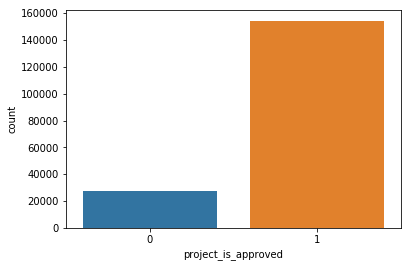

In [9]:
sns.countplot(x='project_is_approved', data=training)
plt.show()

In [10]:
# This shows the min, max, mean, median, etc of the data. There seem to be outliers in the Number of previously posted projects, the number of resources requested (quantity), and total price of the requested resources. Outliers will need to be removed from the dataset. 
training.describe()

,teacher_number_of_previously_posted_projects,project_is_approved,quantity,total_price,min_quantity,max_quantity,min_price,max_price
count,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000,182080.000000
mean,11.237055,0.847682,16.971447,545.748958,4.107354,7.666070,200.047662,353.909315
std,28.016086,0.359330,26.241957,548.198713,11.604126,15.994654,418.833826,475.762385
min,0.000000,0.000000,1.000000,100.000000,1.000000,1.000000,0.000000,2.910000
25%,0.000000,1.000000,4.000000,245.997500,1.000000,1.000000,11.990000,105.000000
50%,2.000000,1.000000,9.000000,397.750000,1.000000,3.000000,44.980000,218.775000
75%,9.000000,1.000000,21.000000,691.920000,2.000000,6.000000,224.700000,416.400000
max,451.000000,1.000000,930.000000,15299.690000,800.000000,800.000000,12344.000000,12344.000000


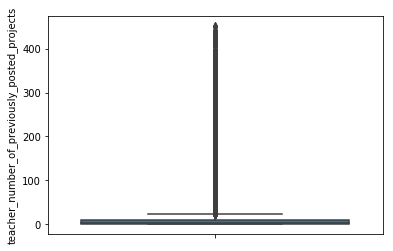

In [11]:
# The plot below shows the total number of previously posted projects. You cannot see the IQR or the median in this plot. It is dominated by the instances that could be outliers.
sns.boxplot(training['teacher_number_of_previously_posted_projects'], orient='v')
plt.show()

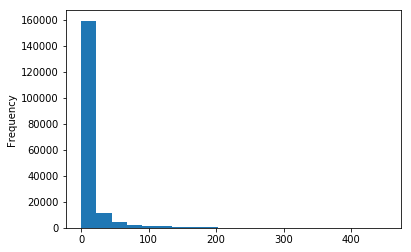

In [12]:
# The histogram of the number of projects is heavily right skewed as well. This can cause issues with machine learning algorithms.
training['teacher_number_of_previously_posted_projects'].plot.hist(bins=20)

In [14]:
# The standard deviation and mean are needed to calculate outliers. The formula used in this analysis for outliers is mean + 2 x standard deviation.
training['teacher_number_of_previously_posted_projects'].mean(), training['teacher_number_of_previously_posted_projects'].std()

(11.237055140597539, 28.01608601938684)

In [15]:
# The value for outliers is > 67.27 previously posted projects.
11.23 + (28.02 * 2)

67.27

In [16]:
training = training[training['teacher_number_of_previously_posted_projects'] < 67.27].reset_index(drop=True)

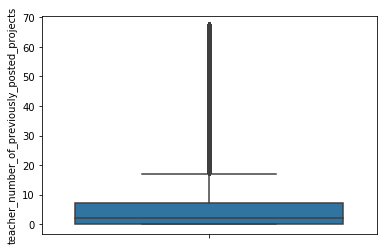

In [17]:
# After removing the outliers, the box portion is more visible before.
sns.boxplot(training['teacher_number_of_previously_posted_projects'], orient='v')
plt.show()

In [18]:
training['teacher_number_of_previously_posted_projects'].describe()

count    175379.000000
mean          6.835625
std          11.533715
min           0.000000
25%           0.000000
50%           2.000000
75%           7.000000
max          67.000000
Name: teacher_number_of_previously_posted_projects, dtype: float64

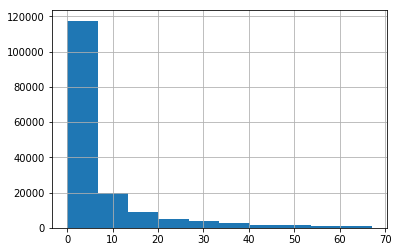

In [110]:
# The data for previously posted projects is still skewed to the right.
training['teacher_number_of_previously_posted_projects'].hist()

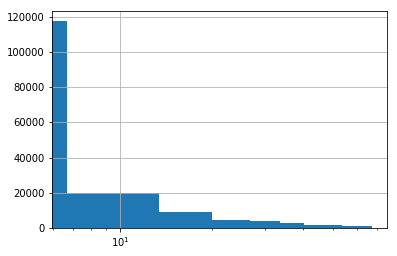

In [115]:
# Taking the log of the values does not change the skew of the data.
training['teacher_number_of_previously_posted_projects'].hist()
plt.xscale('log')

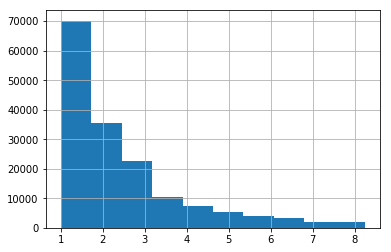

In [113]:
# Taking the square root of the data does a better job of transforming, however this is still skewed. 
np.sqrt(training['teacher_number_of_previously_posted_projects']).hist()

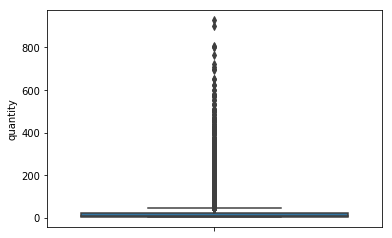

In [19]:
# The quantity of resources requested also contains outliers. The box plot below shows that we cannot see the IQR, median, etc.
sns.boxplot(training['quantity'], orient='v')
plt.show()

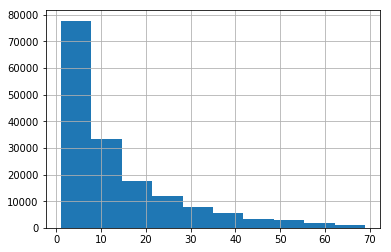

In [116]:
# The quantity feature is right skewed.
training['quantity'].hist()

In [20]:
training['quantity'].mean(), training['quantity'].std()

(16.915024033664235, 26.212416282914326)

In [21]:
# Find the value for outliers (x > 69.32)
16.92 + (2 * 26.2)

69.32

In [22]:
len(training[training['quantity'] > 69.32])

6063

In [23]:
training = training[training['quantity'] < 69.32].reset_index(drop=True)

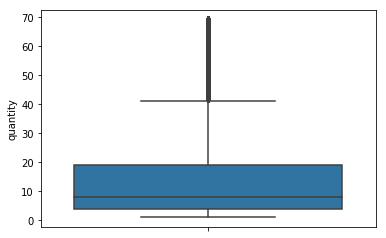

In [24]:
# After removing the outliers, the boxplot is visible. The median is arounf 10.
sns.boxplot(training['quantity'], orient='v')
plt.show()

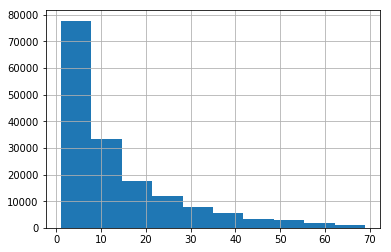

In [117]:
# The quantity feature is still skewed after removing outliers.
training['quantity'].hist()

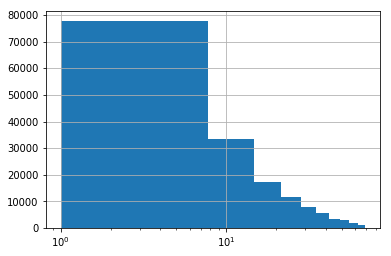

In [118]:
# Taking the log of the quantity feature does not help the skew of the data.
training['quantity'].hist()
plt.xscale('log')

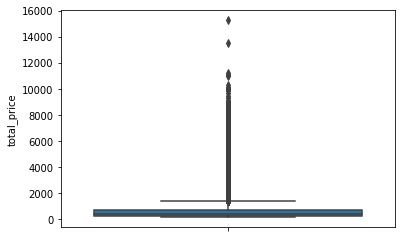

In [28]:
# The box plot of the total price of resources requested has outliers.
sns.boxplot(training['total_price'], orient='v')
plt.show()

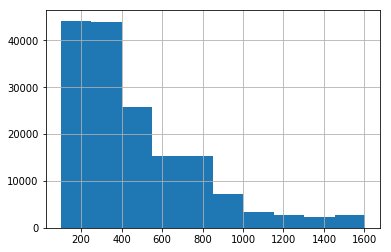

In [120]:
# Just like the previous two features, the total price is also right skewed.
training['total_price'].hist()

In [25]:
training['total_price'].mean(), training['total_price'].std()

(537.268108861507, 533.0489545172296)

In [26]:
537.27 + (2 * 533.05)

1603.37

In [27]:
len(training[training['total_price'] > 1603.37])

6288

In [29]:
training = training[training['total_price'] < 1603.37].reset_index(drop=True)

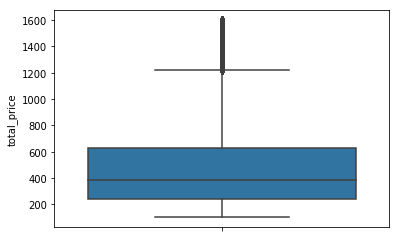

In [30]:
# After removing outliers, the box plot is easier to read.
sns.boxplot(training['total_price'], orient='v')
plt.show()

In [31]:
# We removed roughly 20k rows from the dataset after checking for outliers.
training.shape

(163028, 22)

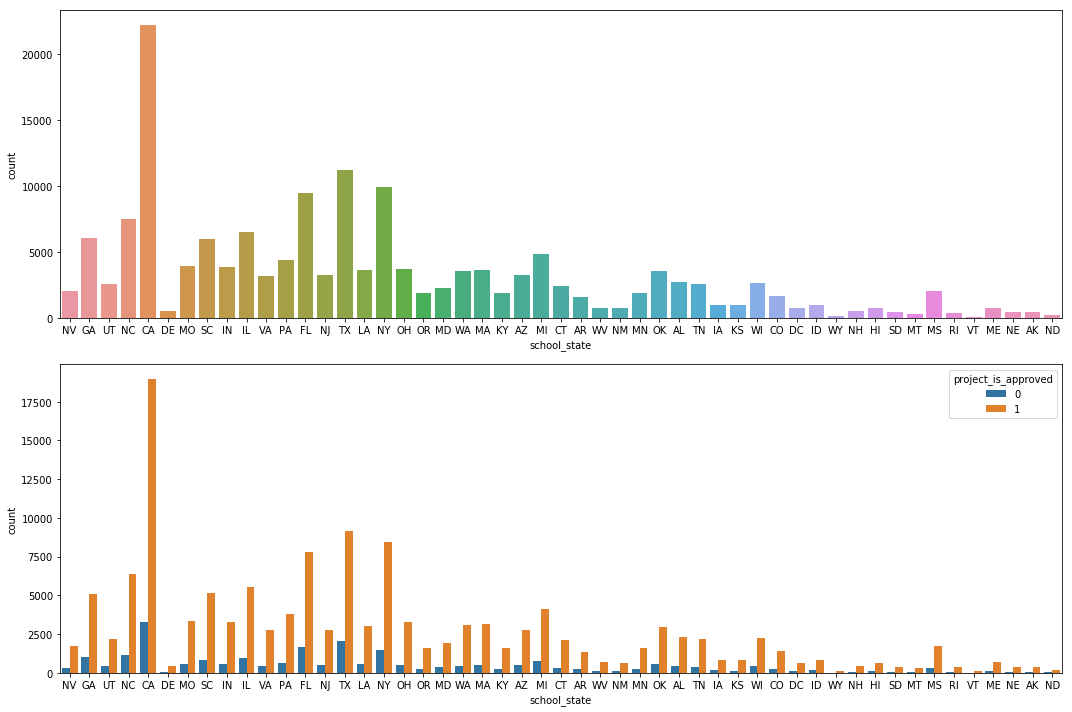

In [32]:
import seaborn as sns
plt.figure(figsize=(15,10))
plt.subplot(2,1,1)
sns.countplot(x='school_state', data=training)

plt.subplot(2,1,2)
sns.countplot(x='school_state', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

The figures above show the breakdown of submissions by state and the breakdown of approved/rejected projects by state. As expected the number of projects submitted in California, Texas, New York, and Florida are the highest.

In [33]:
state_counts = pd.DataFrame(training['school_state'].value_counts())

In [34]:
state_counts['state'] = state_counts.index
state_counts.reset_index(drop=True, inplace=True)
state_counts.head()

,school_state,state
0,22209,CA
1,11236,TX
2,9936,NY
3,9481,FL
4,7500,NC


In [35]:
import plotly as py
py.tools.set_credentials_file(username='matthewcassi', api_key='FRBXjPQX0Xkx8wtIerG0')

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],[0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

state_counts['text'] = 'Number of Applications ' + state_counts['school_state'].astype('str')

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = state_counts['state'],
        z = state_counts['school_state'],
        locationmode = 'USA-states',
        text = state_counts['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "Number of Apps")
        ) ]

layout = dict(
        title = 'Number of DonorsChoose Applications by State',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)'),
             )
    
fig = dict( data=data, layout=layout )
py.plotly.iplot( fig, filename='donors_choose' )

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~matthewcassi/0 or inside your plot.ly account where it is named 'donors_choose'


The map above shows the number of submissions by state. Just a different way to view the data from above.

In [36]:
# Creating a table of states vs approved and rejected.
state = pd.pivot_table(training, index='school_state', columns='project_is_approved', values='id', aggfunc=len)

In [37]:
# Creating additional columns of the ratios of rejections and approvals within each state.
state['per_rejected'] = (state[0]) / (state[0] + state[1])
state['per_approved'] = (state[1]) / (state[0] + state[1])

In [38]:
# Creating the proportion of approvals within the entire dataset 
state['per_approved_total'] = (state[1]) / (state[1].sum(axis=0))

In [39]:
# Creating the proportion of rejections within the entire dataset 
state['per_rejected_total'] = (state[0]) / (state[0].sum(axis=0))

In [40]:
# The table below shows a breakdown of all the rejection and approval stats for each state. Every state has an acceptance rate of greater than 0.8. The last two columns show more data to backup the fact that California, Texas, New York, and Florida all have more submissions. !3% of all approvals and rejections come from California.
state

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
school_state,,,,,,
AK,72,390,0.155844,0.844156,0.002826,0.002880
AL,415,2329,0.151239,0.848761,0.016874,0.016599
AR,271,1343,0.167906,0.832094,0.009730,0.010839
AZ,522,2778,0.158182,0.841818,0.020127,0.020878
CA,3254,18955,0.146517,0.853483,0.137329,0.130150
CO,262,1404,0.157263,0.842737,0.010172,0.010479
CT,319,2116,0.131006,0.868994,0.015330,0.012759
DC,135,615,0.180000,0.820000,0.004456,0.005400
DE,57,460,0.110251,0.889749,0.003333,0.002280


In [41]:
# Most projects are submitted by female teachers. 
training['teacher_prefix'].value_counts()

Mrs.       86638
Ms.        57905
Mr.        14917
Teacher     3541
Dr.           23
Name: teacher_prefix, dtype: int64

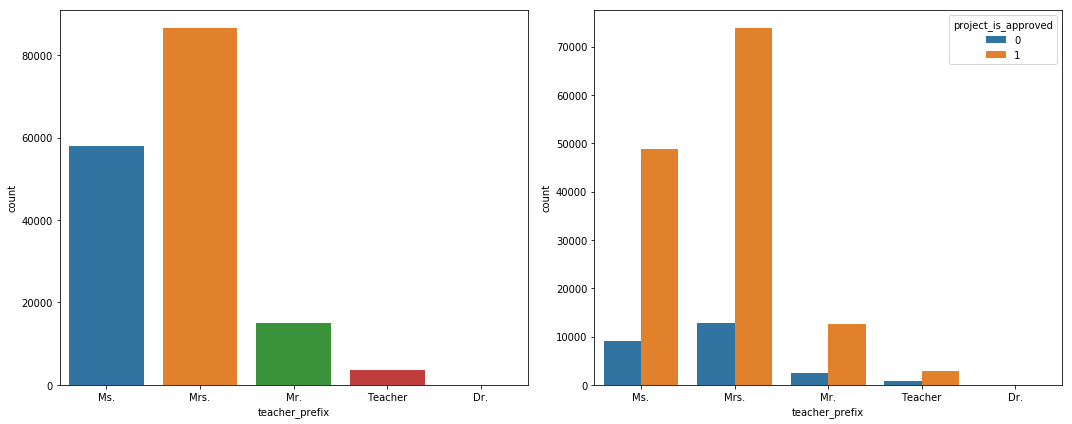

In [42]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='teacher_prefix', data=training)

plt.subplot(1,2,2)
sns.countplot(x='teacher_prefix', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

The charts above show the breakdown of the gender/teacher type of the submissions. Female teachers dominate the number of submissions.

In [43]:
# Creating a table of approvals/rejections by teacher type
teacher = pd.pivot_table(training, index='teacher_prefix', columns='project_is_approved', values='id', aggfunc=len)

In [44]:
# Creating proportions within groups and within the entire dataset.
teacher['per_rejected'] = (teacher[0]) / (teacher[0] + teacher[1])
teacher['per_approved'] = (teacher[1]) / (teacher[0] + teacher[1])
teacher['per_approved_total'] = (teacher[1]) / ( teacher[1].sum(axis=0))
teacher['per_rejected_total'] = (teacher[0]) / (teacher[0].sum(axis=0))

In [45]:
teacher

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
teacher_prefix,,,,,,
Dr.,5,18,0.217391,0.782609,0.000130,0.000200
Mr.,2359,12558,0.158142,0.841858,0.090985,0.094352
Mrs.,12754,73884,0.147210,0.852790,0.535306,0.510119
Ms.,9161,48744,0.158207,0.841793,0.353161,0.366411
Teacher,723,2818,0.204180,0.795820,0.020417,0.028918


The table above reaffirms the conclusion that female teachers are submitting more projects than any other teacher type. They account for > 80% of the submissions.

In [46]:
# Most projects come from ealier grades (K through 5).
training['project_grade_category'].value_counts()

Grades PreK-2    68183
Grades 3-5       55394
Grades 6-8       24228
Grades 9-12      15223
Name: project_grade_category, dtype: int64

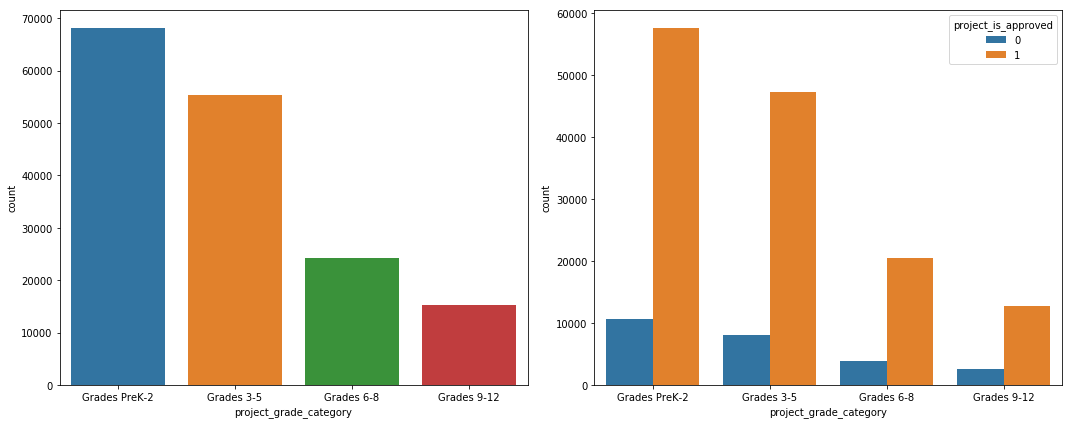

In [47]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.countplot(x='project_grade_category', data=training)

plt.subplot(1,2,2)
sns.countplot(x='project_grade_category', hue='project_is_approved', data=training)

plt.tight_layout()
plt.show()

The plots above show the graphical representation of the number of submissions based on the grade and the breakdown of approvals and rejections.

In [48]:
grade = pd.pivot_table(training, index='project_grade_category', columns='project_is_approved', values='id', aggfunc=len)

In [49]:
grade['per_rejected'] = (grade[0]) / (grade[0] + grade[1])
grade['per_approved'] = (grade[1]) / (grade[0] + grade[1])
grade['per_approved_total'] = (grade[1]) / ( grade[1].sum(axis=0))
grade['per_rejected_total'] = (grade[0]) / (grade[0].sum(axis=0))

In [50]:
grade

project_is_approved,0,1,per_rejected,per_approved,per_approved_total,per_rejected_total
project_grade_category,,,,,,
Grades 3-5,8128,47266,0.146731,0.853269,0.342443,0.325094
Grades 6-8,3800,20428,0.156843,0.843157,0.148001,0.151988
Grades 9-12,2508,12715,0.164751,0.835249,0.092120,0.100312
Grades PreK-2,10566,57617,0.154965,0.845035,0.417436,0.422606


The table above shows the breakdown of submissions within each grade and within the entire dataset. This just reaffirms the conclusion that Grades K-5 dominate the dataset.
<br><br>
The project categories and subcategories both contain lists of values. These will need to be separated to gather the tallies for each category and subcategory,

In [51]:
training['project_subject_categories'].value_counts()

Literacy & Language                           35265
Math & Science                                25436
Literacy & Language, Math & Science           22642
Health & Sports                               15379
Music & The Arts                               7141
Special Needs                                  6684
Literacy & Language, Special Needs             6081
Applied Learning                               5780
Math & Science, Literacy & Language            3327
Applied Learning, Literacy & Language          3312
Math & Science, Special Needs                  2709
History & Civics                               2684
Literacy & Language, Music & The Arts          2460
Applied Learning, Special Needs                2316
Math & Science, Music & The Arts               2295
Health & Sports, Special Needs                 2238
History & Civics, Literacy & Language          1925
Math & Science, Applied Learning               1793
Warmth, Care & Hunger                          1761
Applied Lear

In [52]:
training['project_subject_categories'].unique()

array(['Literacy & Language', 'Music & The Arts, Health & Sports',
       'Math & Science, Literacy & Language', 'Health & Sports',
       'Applied Learning, Literacy & Language', 'Math & Science',
       'Literacy & Language, Math & Science', 'Special Needs',
       'Applied Learning, Special Needs',
       'Applied Learning, Music & The Arts',
       'Math & Science, Special Needs', 'Health & Sports, Special Needs',
       'Literacy & Language, History & Civics',
       'Health & Sports, Literacy & Language', 'Music & The Arts',
       'Literacy & Language, Special Needs',
       'Special Needs, Music & The Arts', 'History & Civics',
       'Math & Science, Applied Learning',
       'Literacy & Language, Music & The Arts',
       'Math & Science, Music & The Arts',
       'History & Civics, Special Needs',
       'History & Civics, Literacy & Language', 'Applied Learning',
       'Math & Science, History & Civics',
       'Applied Learning, Math & Science',
       'Health & Sports, A

In [53]:
len(training['project_subject_categories'].unique())

51

In [54]:
training['project_subject_subcategories'].value_counts()

Literacy                                        14441
Literacy, Mathematics                           12964
Literature & Writing, Mathematics                9083
Mathematics                                      8229
Literacy, Literature & Writing                   8180
Special Needs                                    6684
Literature & Writing                             6565
Health & Wellness                                5546
Applied Sciences, Mathematics                    5116
Literacy, Special Needs                          3729
Applied Sciences                                 3667
Gym & Fitness, Health & Wellness                 3493
ESL, Literacy                                    3308
Visual Arts                                      2993
Music                                            2130
Literature & Writing, Special Needs              2040
Health & Wellness, Special Needs                 1935
Gym & Fitness                                    1808
Mathematics, Special Needs  

In [55]:
# Removing a comma so we can split on the comma
training['project_subject_categories'] = training['project_subject_categories'].str.replace('Warmth, Care & Hunger', 'Warmth Care & Hunger')

In [56]:
# Removing a comma so we can split of the comma
training['project_subject_subcategories'] = training['project_subject_subcategories'].str.replace('Warmth, Care & Hunger', 'Warmth Care & Hunger')

In [57]:
training['project_subject_subcategories'].value_counts()

Literacy                                        14441
Literacy, Mathematics                           12964
Literature & Writing, Mathematics                9083
Mathematics                                      8229
Literacy, Literature & Writing                   8180
Special Needs                                    6684
Literature & Writing                             6565
Health & Wellness                                5546
Applied Sciences, Mathematics                    5116
Literacy, Special Needs                          3729
Applied Sciences                                 3667
Gym & Fitness, Health & Wellness                 3493
ESL, Literacy                                    3308
Visual Arts                                      2993
Music                                            2130
Literature & Writing, Special Needs              2040
Health & Wellness, Special Needs                 1935
Gym & Fitness                                    1808
Mathematics, Special Needs  

In [58]:
# Split on the comma
training['project_subject_categories'] = list(training['project_subject_categories'].str.split(r', '))

In [59]:
training['project_subject_categories'][3]

['Health & Sports']

In [60]:
# Create a dataframe of the counts for each row
training1 = training['project_subject_categories'].apply(collections.Counter)
training1 = pd.DataFrame.from_records(training1).fillna(value=0)

In [61]:
training1.shape

(163028, 8)

In [62]:
# Split on the comma
training['project_subject_subcategories'] = list(training['project_subject_subcategories'].str.split(r', '))

In [63]:
training['project_subject_subcategories'][2]

['Applied Sciences', 'Literature & Writing']

In [64]:
# Create a dataframe of the counts for each row
training2 = training['project_subject_subcategories'].apply(collections.Counter)
training2 = pd.DataFrame.from_records(training2).fillna(value=0)

In [65]:
training2.shape

(163028, 29)

In [66]:
# Left join the category data together with the training set
training = training.merge(training1, how='left', left_index=True, right_index=True)

In [67]:
# Left join the subcategory data together with the training set
training = training.merge(training2, how='left', left_index=True, right_index=True)

In [68]:
# Drop the originals
training.drop(['project_subject_subcategories', 'project_subject_categories'], 1, inplace=True)

In [69]:
training.head()

,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,...,Music,Nutrition Education,Other,Parent Involvement,Performing Arts,Social Sciences,Special Needs_y,Team Sports,Visual Arts,Warmth Care & Hunger_y
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [70]:
training.shape

(163028, 57)

In [71]:
list(training.columns)

['id',
 'teacher_id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved',
 'quantity',
 'total_price',
 'min_quantity',
 'max_quantity',
 'min_price',
 'max_price',
 'Applied Learning',
 'Health & Sports',
 'History & Civics',
 'Literacy & Language',
 'Math & Science',
 'Music & The Arts',
 'Special Needs_x',
 'Warmth Care & Hunger_x',
 'Applied Sciences',
 'Character Education',
 'Civics & Government',
 'College & Career Prep',
 'Community Service',
 'ESL',
 'Early Development',
 'Economics',
 'Environmental Science',
 'Extracurricular',
 'Financial Literacy',
 'Foreign Languages',
 'Gym & Fitness',
 'Health & Life Science',
 'Health & Wellness',
 'History & Geography',
 'Literacy',
 'Literature & Writing',
 'Mathematics',
 'Music',
 'Nutrition Ed

In [72]:
cat_totals = pd.DataFrame(training.loc[:,'Applied Learning':'Applied Sciences'].sum(axis=0))

In [73]:
cat_totals['category'] = cat_totals.index
cat_totals.columns = ['count','category']
cat_totals.reset_index(drop=True, inplace=True)
cat_totals

,count,category
0,18219.0,Applied Learning
1,21656.0,Health & Sports
2,8287.0,History & Civics
3,78400.0,Literacy & Language
4,62164.0,Math & Science
5,14269.0,Music & The Arts
6,21053.0,Special Needs_x
7,1878.0,Warmth Care & Hunger_x
8,15843.0,Applied Sciences


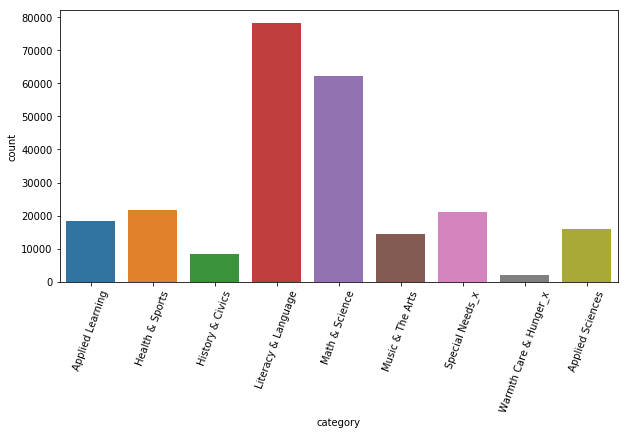

In [74]:
plt.figure(figsize=(10,5))
sns.barplot(x='category', y='count', data=cat_totals)
plt.xticks(rotation=70)
plt.show()

The plot and tables above show the most projects are grouped under literacy/language and math/science.

In [75]:
subcat_totals = pd.DataFrame(training.loc[:,'Applied Sciences':].sum(axis=0))
subcat_totals['category'] = subcat_totals.index
subcat_totals.columns = ['count','category']
subcat_totals.reset_index(drop=True, inplace=True)

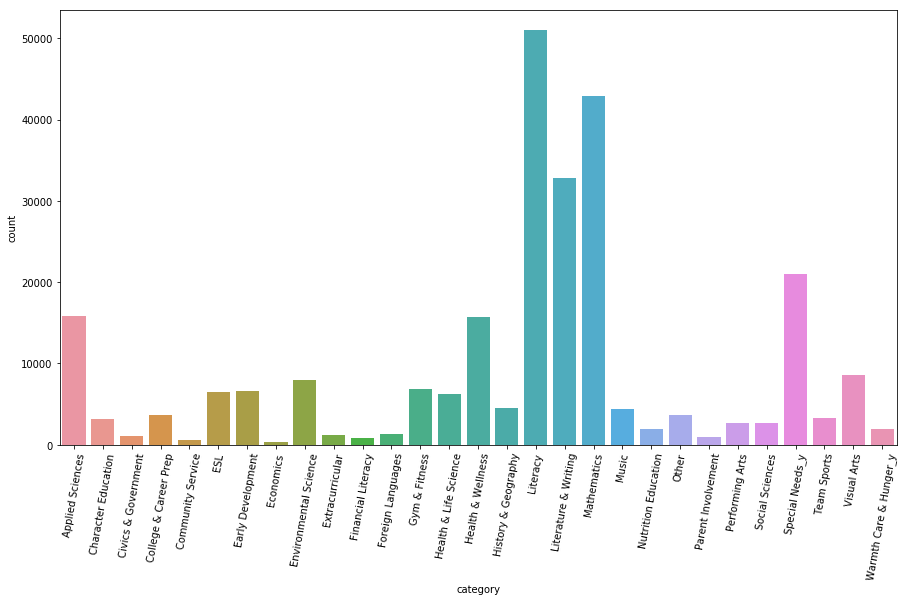

In [76]:
plt.figure(figsize=(15,8))
sns.barplot(x='category', y='count', data=subcat_totals)
plt.xticks(rotation=80)
plt.show()

The plot and tables above show the subcategories literacy, literature/writing, and math have the most submissions.

# Text Cleaning

In [77]:
# Converting all text to lower case
training['project_title'] = training['project_title'].str.lower()
training['project_essay_1'] = training['project_essay_1'].str.lower()
training['project_essay_2'] = training['project_essay_2'].str.lower()
training['project_essay_3'] = training['project_essay_3'].str.lower()
training['project_essay_4'] = training['project_essay_4'].str.lower()
training['project_resource_summary'] = training['project_resource_summary'].str.lower()

In [121]:
# Fixing contractions and spelling errors. See the accompanying notebook for how misspellings were determined.

In [78]:
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_title'] = training['project_title'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [79]:
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_essay_1'] = training['project_essay_1'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [80]:
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_essay_2'] = training['project_essay_2'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [81]:
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_essay_3'] = training['project_essay_3'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [82]:
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_essay_4'] = training['project_essay_4'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [83]:
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])haven\'t(?![a-z])', 'have not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])i\'m(?![a-z])', 'i am', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])i\'ll(?![a-z])', 'i will', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])i\'ve(?![a-z])', 'i have', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])can\'t(?![a-z])', 'can not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])you\'re(?![a-z])', 'you are', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])isn\'t(?![a-z])', 'is not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])you\'ll(?![a-z])', 'you will', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])you\'ve(?![a-z])', 'you have', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])he\'s(?![a-z])', 'he is', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])he\'ll(?![a-z])', 'he will', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])she\'s(?![a-z])', 'she is', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])it\'s(?![a-z])', 'it is', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])it\'ll(?![a-z])', 'it will', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])we\'re(?![a-z])', 'we are', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])we\'ll(?![a-z])', 'we will', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])they\'re(?![a-z])', 'they are', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])that\'s(?![a-z])', 'that is', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])wasn\'t(?![a-z])', 'was not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])weren\'t(?![a-z])', 'were not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])aren\'t(?![a-z])', 'are not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])hasn\'t(?![a-z])', 'has not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])hadn\'t(?![a-z])', 'had not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])won\'t(?![a-z])', 'will not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])wouldn\'t(?![a-z])', 'would', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])don\'t(?![a-z])', 'do not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])doesn\'t(?![a-z])', 'does not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])didn\'t(?![a-z])', 'did not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])couldn\'t(?![a-z])', 'could not', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])shouldn\'t(?![a-z])', 'should not', case=False)

training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])inforgraphics(?![a-z])', 'information graphics', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])googlin(?![a-z])', 'googling', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])incoroporate(?![a-z])', 'incorporate', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])ultraportable(?![a-z])', 'ultra portable', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])succcesful(?![a-z])', 'successful', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])doble(?![a-z])', 'double', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])aromatherepy(?![a-z])', 'aromatherapy', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])resorces(?![a-z])', 'resources', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])strugglling(?![a-z])', 'struggling', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])consitstantly(?![a-z])', 'consistantly', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])piller(?![a-z])', 'pillar', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])technosavy(?![a-z])', 'tech-savy', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])unheathy(?![a-z])', 'unhealthy', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])experiance(?![a-z])', 'experience', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])somthing(?![a-z])', 'something', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])wonderoplois(?![a-z])', 'wonderopolis', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])visionmaker(?![a-z])', 'vision maker', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])visititing(?![a-z])', 'visiting', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])magnaformers(?![a-z])', 'magformers', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])scheving(?![a-z])', 'skeeving', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])juicin(?![a-z])', 'juicing', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])applocation(?![a-z])', 'application', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])fifeteen(?![a-z])', 'fifteen', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])dissappearing(?![a-z])', 'disappearing', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])lern(?![a-z])', 'learn', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])nesecarry(?![a-z])', 'necessary', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])instructuion(?![a-z])', 'instruction', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])famlies(?![a-z])', 'families', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])flipcamera(?![a-z])', 'flip camera', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])geaux(?![a-z])', 'go', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])fullly(?![a-z])', 'fully', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])fitbrain(?![a-z])', 'fit brain', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])gameup(?![a-z])', 'game up', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])typcially(?![a-z])', 'typically', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])helprobably(?![a-z])', 'he probably', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])chillout(?![a-z])', 'chill out', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])scientits(?![a-z])', 'scientists', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])subsistance(?![a-z])', 'subsistence', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])attaaack(?![a-z])', 'attack', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])healthysnacks(?![a-z])', 'healthy snacks', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])assessements(?![a-z])', 'assessments', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])allegeries(?![a-z])', 'allergies', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])dyanmath(?![a-z])', 'dynamath', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])spiltters(?![a-z])', 'splitters', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])surronded(?![a-z])', 'surrounded', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])utilitze(?![a-z])', 'utilize', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])nregular(?![a-z])', 'regular', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])readinglanugage(?![a-z])', 'reading language', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])acadamy(?![a-z])', 'academy', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])resortativr(?![a-z])', 'restorative', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])emphasising(?![a-z])', 'emphasizing', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])ctivity(?![a-z])', 'activity', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])hygeine(?![a-z])', 'hygiene', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])meterstick(?![a-z])', 'meter stick', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])expourse(?![a-z])', 'exposure', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])approachs(?![a-z])', 'approaches', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])andtwo(?![a-z])', 'and two', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])fitibits(?![a-z])', 'fit bits', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])thesee(?![a-z])', 'these', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])pesonally(?![a-z])', 'personally', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])efective(?![a-z])', 'effective', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])durring(?![a-z])', 'during', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])sdljlkjasdf(?![a-z])', '', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])indesdructable(?![a-z])', 'indestructable', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])responisble(?![a-z])', 'responsible', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])teammwork(?![a-z])', 'teamwork', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])mathmetician(?![a-z])', 'mathematician', case=False)
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'(?<![a-z])ofachild(?![a-z])', 'of a child', case=False)

In [84]:
# Remove all non-letters and spaces from the project title
training['project_title'] = training['project_title'].str.replace(r'[^a-zA-Z ]+', '')

In [85]:
# Remove all non-letters and spaces from the remaining text fields
training['project_essay_1'] = training['project_essay_1'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_2'] = training['project_essay_2'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_3'] = training['project_essay_3'].str.replace(r'[^a-zA-Z ]+', '')
training['project_essay_4'] = training['project_essay_4'].str.replace(r'[^a-zA-Z ]+', '')
training['project_resource_summary'] = training['project_resource_summary'].str.replace(r'[^a-zA-Z ]+', '')

In [86]:
# Replacing NANs with ''
training['project_essay_3'] = training['project_essay_3'].fillna('')
training['project_essay_4'] = training['project_essay_4'].fillna('')

In [87]:
# Getting the word counts prior to removing stop words
training['essay1_count'] = training['project_essay_1'].str.split().str.len()
training['essay2_count'] = training['project_essay_2'].str.split().str.len()
training['essay3_count'] = training['project_essay_3'].str.split().str.len()
training['essay4_count'] = training['project_essay_4'].str.split().str.len()
training['project_resource_summary_count'] = training['project_resource_summary'].str.split().str.len()

In [88]:
training['essay3_count'].head()

0    0
1    0
2    0
3    0
4    0
Name: essay3_count, dtype: int64

In [89]:
# Removing stop words (words that do not add value like a, but, the, etc.) from each text column.
from nltk.corpus import stopwords
stop = stopwords.words('english')

training['project_title'] = training['project_title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_1'] = training['project_essay_1'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_2'] = training['project_essay_2'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_3'] = training['project_essay_3'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_essay_4'] = training['project_essay_4'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
training['project_resource_summary'] = training['project_resource_summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

The plots below show the most popular words from each text field as well as word clouds for each field. The essays contain the word 'students' much more than any other word, which is to be expected. The title contains technology more than any other word, which is also not surprising.

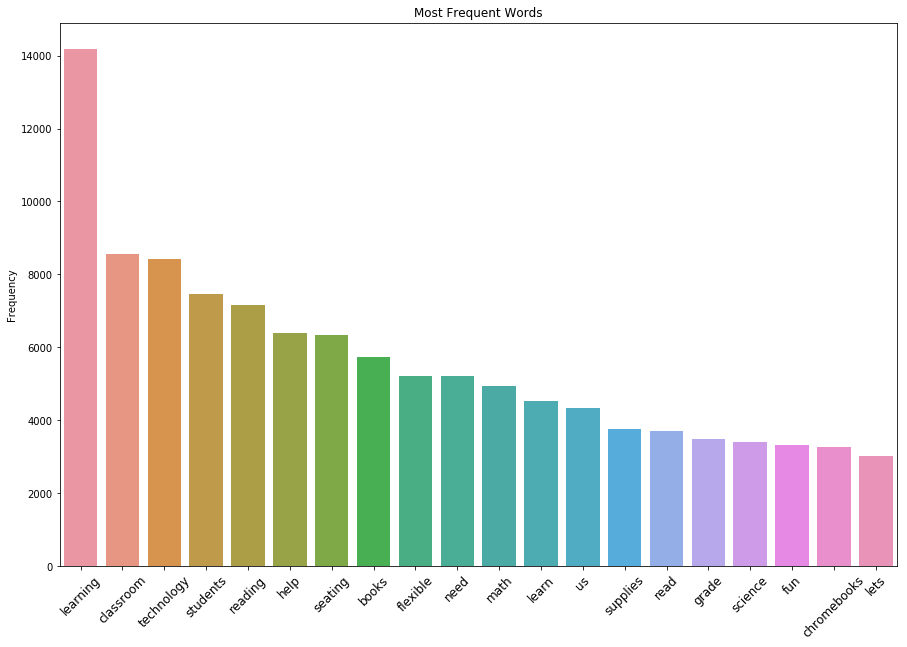

In [90]:
title = ' '.join(training['project_title'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

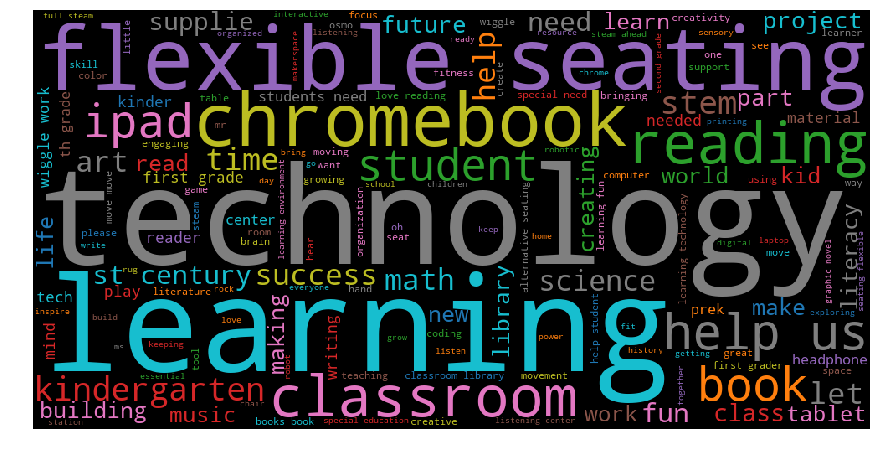

In [91]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_title']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

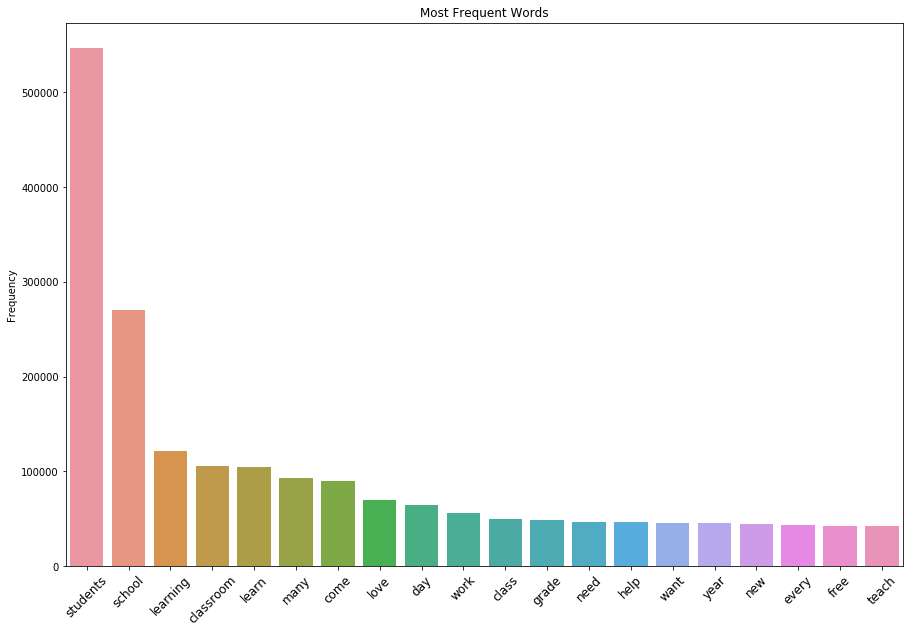

In [92]:
title = ' '.join(training['project_essay_1'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

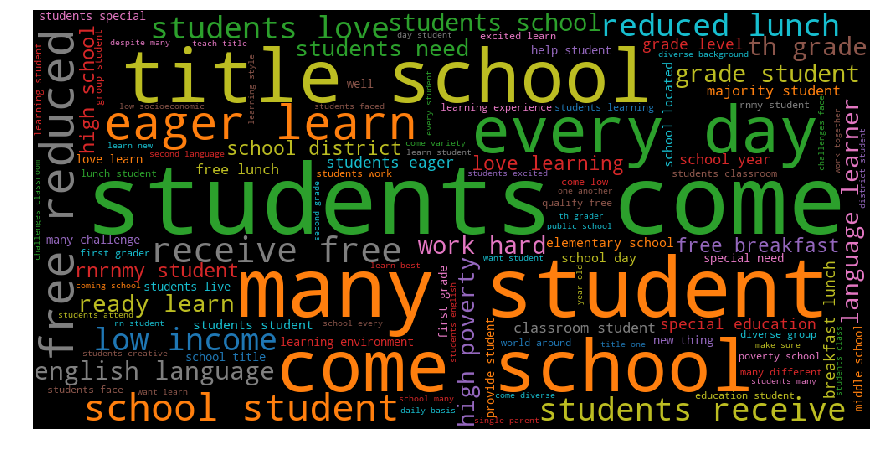

In [93]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_essay_1']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

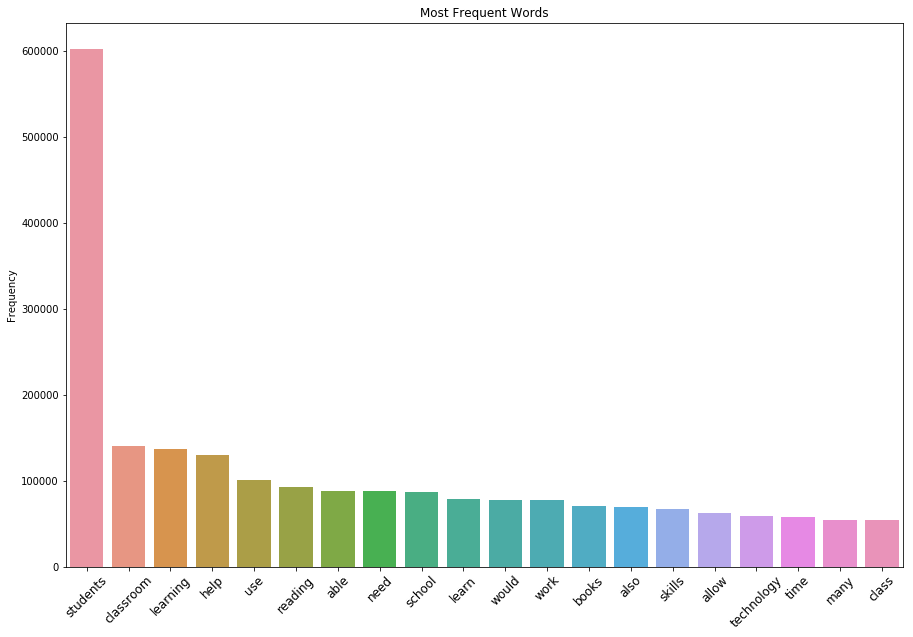

In [94]:
title = ' '.join(training['project_essay_2'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

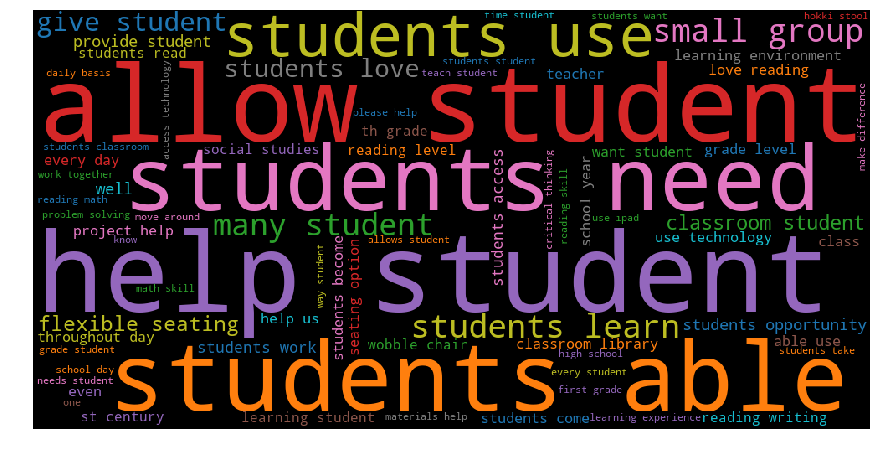

In [95]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_essay_2']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

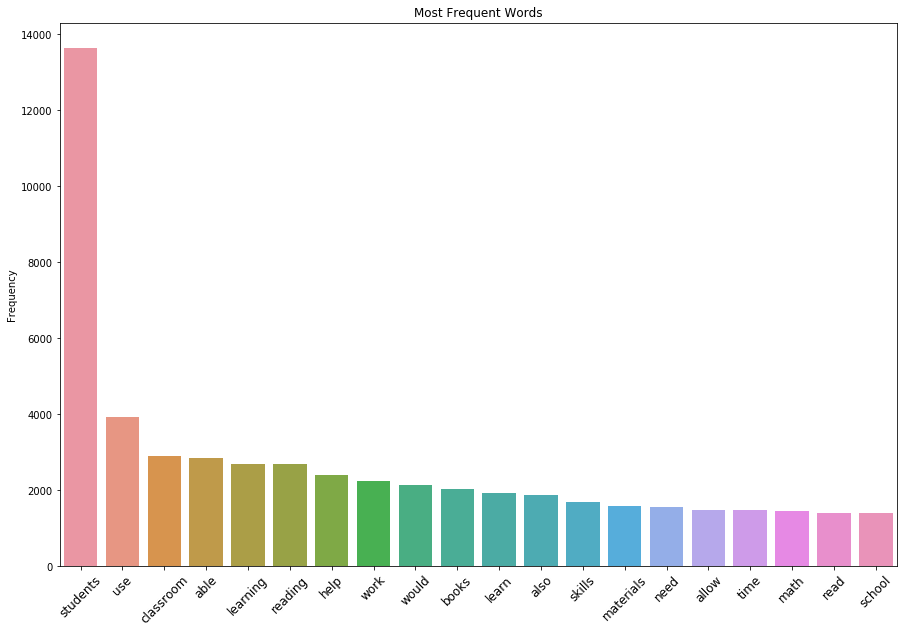

In [96]:
title = ' '.join(training['project_essay_3'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

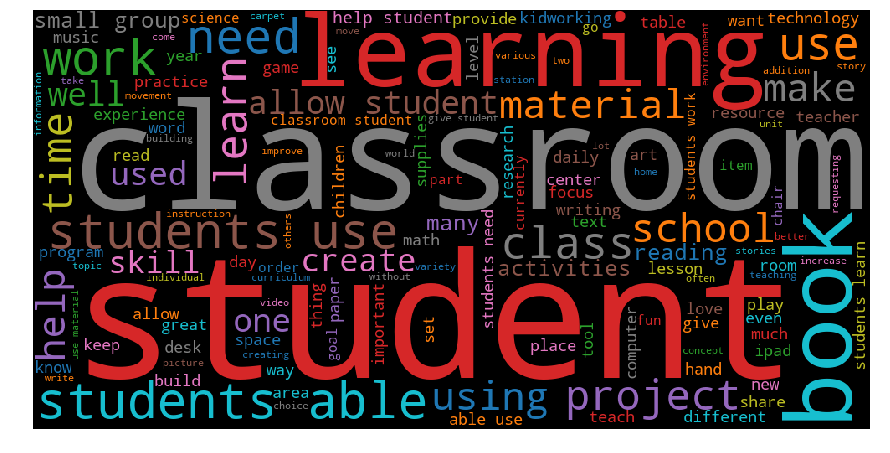

In [97]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_essay_3']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

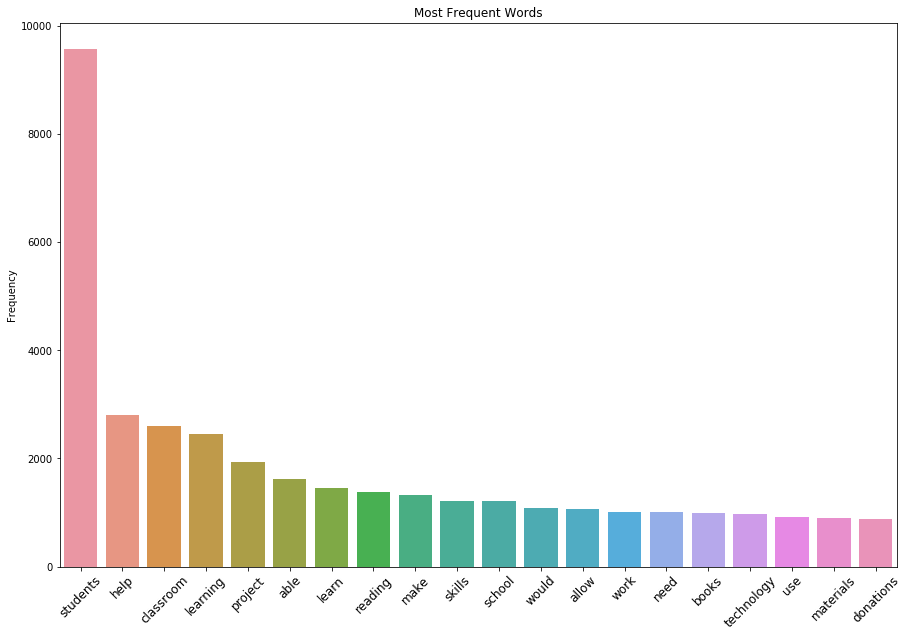

In [98]:
title = ' '.join(training['project_essay_4'])
tokens = nltk.tokenize.word_tokenize(title)
freq = FreqDist(tokens)
freq1 = freq.most_common(20)
word, count = zip(*freq1)
word = list(word)
count = list(count)

plt.figure(figsize=(15,10))
sns.barplot(np.arange(len(word)), count)
plt.xticks(np.arange(len(word)), word, rotation=45, size='large')
plt.ylabel('Frequency')
plt.title('Most Frequent Words')
plt.show()

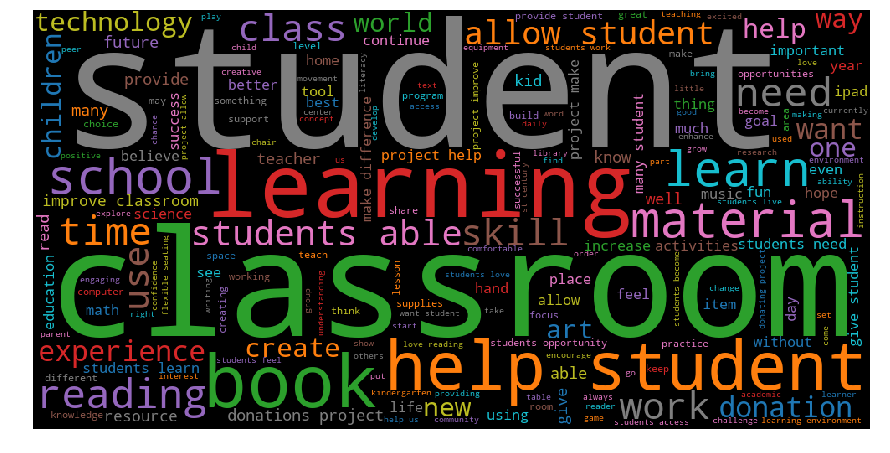

In [99]:
wordcloud = WordCloud(width = 1000, height = 500,colormap='tab10', min_font_size=10).generate(' '.join(training['project_essay_4']))
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [100]:
# Getting the word counts on text fields after removing stop words
training['essay1_count_nostop'] = training['project_essay_1'].str.split().str.len()
training['essay2_count_nostop'] = training['project_essay_2'].str.split().str.len()
training['essay3_count_nostop'] = training['project_essay_3'].str.split().str.len()
training['essay4_count_nostop'] = training['project_essay_4'].str.split().str.len()
training['proj_resouce_count_nostop'] = training['project_resource_summary'].str.split().str.len()

In [102]:
# Dropping the teacher ID
training.drop('teacher_id', 1, inplace=True)

In [103]:
# Removing subcategories that are duplicates
training.drop('Warmth Care & Hunger_y', 1, inplace=True)
training.drop('Special Needs_y', 1, inplace=True)

In [104]:
# Creating functions that handle lemmatization
def tag_and_remove(data_str):
    cleaned_str = ' '
    # noun tags
    nn_tags = ['NN', 'NNP', 'NNP', 'NNPS', 'NNS']
    # adjectives
    jj_tags = ['JJ', 'JJR', 'JJS']
    # verbs
    vb_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
    #adverbs
    av_tags = ['RB','RBR','RBS']
    nltk_tags = nn_tags + jj_tags + vb_tags + av_tags

    # break string into 'words'
    text = data_str.split()

    # tag the text and keep only those with the right tags
    #tagged_text = pos_tag(text)
    tagged_text = tagger.tag(text)
    for tagged_word in tagged_text:
        if tagged_word[1] in nltk_tags:
            cleaned_str += tagged_word[0] + ' '

    return cleaned_str

def lemmatize(data_str):
    # expects a string
    list_pos = 0
    cleaned_str = ''
    lmtzr = WordNetLemmatizer()
    text = data_str.split()
    #tagged_words = pos_tag(text)
    tagged_words = tagger.tag(text)
    for word in tagged_words:
        if 'v' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='v')
        elif 'r' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='r')
        elif 'a' in word[1].lower():
            lemma = lmtzr.lemmatize(word[0], pos='a')
        else:
            lemma = lmtzr.lemmatize(word[0], pos='n')
        if list_pos == 0:
            cleaned_str = lemma
        else:
            cleaned_str = cleaned_str + ' ' + lemma
        list_pos += 1
    return cleaned_str

In [105]:
# Combining all of the text columns
training['full_text'] = training[['project_title','project_essay_1','project_essay_2','project_essay_3','project_essay_4','project_resource_summary']].apply(lambda x: ' '.join(x.astype(str)), axis=1)

In [106]:
# Lemmatizing the text
tagger = PerceptronTagger()
training['tag_text'] = training['full_text'].apply(tag_and_remove)
training['lemm_text'] = training['tag_text'].apply(lemmatize)

In [107]:
training.head()

,id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,...,essay1_count_nostop,essay2_count_nostop,essay3_count_nostop,essay4_count_nostop,proj_resouce_count_nostop,month,year,full_text,tag_text,lemm_text
0,p036502,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,super sight word centers,kindergarten students come lowincome household...,currently differentiated sight word center dai...,,,...,80,72,0,0,13,11,2016,super sight word centers kindergarten students...,super sight word centers kindergarten student...,super sight word center kindergarten student c...
1,p039565,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,keep calm dance,elementary school culturally rich school diver...,strive provide diverse population students ext...,,,...,54,54,0,0,8,4,2017,keep calm dance elementary school culturally r...,keep calm dance elementary school culturally ...,keep calm dance elementary school culturally r...
2,p233823,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,lets doodle learn,hellornmy name mrs brotherton teach th grade a...,looking add doodler classroom would wonderful ...,,,...,80,47,0,0,18,1,2017,lets doodle learn hellornmy name mrs brotherto...,lets doodle learn hellornmy name mrs brothert...,let doodle learn hellornmy name mr brotherton ...
3,p185307,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,kid inspired equipment increase activities gai...,students greatest students socially economical...,students project totally kidinspireddecided ne...,,,...,95,91,0,0,19,8,2016,kid inspired equipment increase activities gai...,kid inspired equipment increase activities ga...,kid inspire equipment increase activity gain w...
4,p013780,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,need clean water culinary arts class,students athletes students interested health p...,reason kitchen water comes faucet white lookin...,,,...,36,49,0,0,8,8,2016,need clean water culinary arts class students ...,need clean water culinary arts class students...,need clean water culinary art class student at...


In [101]:
# Extracting the month and the year from the data
training['month'] = training['project_submitted_datetime'].dt.month
training['year'] = training['project_submitted_datetime'].dt.year

In [108]:
list(training.columns)

['id',
 'teacher_prefix',
 'school_state',
 'project_submitted_datetime',
 'project_grade_category',
 'project_title',
 'project_essay_1',
 'project_essay_2',
 'project_essay_3',
 'project_essay_4',
 'project_resource_summary',
 'teacher_number_of_previously_posted_projects',
 'project_is_approved',
 'quantity',
 'total_price',
 'min_quantity',
 'max_quantity',
 'min_price',
 'max_price',
 'Applied Learning',
 'Health & Sports',
 'History & Civics',
 'Literacy & Language',
 'Math & Science',
 'Music & The Arts',
 'Special Needs_x',
 'Warmth Care & Hunger_x',
 'Applied Sciences',
 'Character Education',
 'Civics & Government',
 'College & Career Prep',
 'Community Service',
 'ESL',
 'Early Development',
 'Economics',
 'Environmental Science',
 'Extracurricular',
 'Financial Literacy',
 'Foreign Languages',
 'Gym & Fitness',
 'Health & Life Science',
 'Health & Wellness',
 'History & Geography',
 'Literacy',
 'Literature & Writing',
 'Mathematics',
 'Music',
 'Nutrition Education',
 'Oth

In [109]:
training.to_csv('train_clean.csv')